In [40]:
import yaml
import os
from pathlib import Path
import pandas as pd
import struct
import random
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import sys
import math

# also: cd hammer && pip install -e . 

# Setup

In [41]:
# experiment setup
PDK = 'sky130'
CLOCK_PERIOD = 10 if PDK == 'sky130' else 2 # ns

# generate custom make str for each test
make_extra = f"pdk={PDK}"
if PDK == 'intech22': make_extra += f" PDK_CONF=experiments/intech22.yml"

# useful paths
energy_char_dpath = Path(os.getcwd()).parent
tests_dpath = energy_char_dpath/f'experiments/tests-{PDK}'
tests_dpath

PosixPath('/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130')

# Generate experiment files

In [103]:
# get pdk clock periods, paths
PDKs = ["sky130"]
test_paths = {}
for pdk in PDKs:
    test_paths[pdk] = energy_char_dpath/f'experiments/tests-{pdk}'

operations = ['add', 'mul']
op_to_inst = {'add':'adder0', 'mul':'multiplier0'}
num_inputs = 50
widths = [4, 8, 16, 32, 64]
activity_factors = [0.1, 0.5, 0.9, 1.0, 2.0] # eventually include: 0.3,0.7
all_designs = {} ## add16_10ns, mul32_50ns, etc. 

width_to_max = {}
for i in widths:
    width_to_max[i] = (1 << i) - 1
# tests dict
#   name format: <design>-<test_name>
#       inputs: list, where each item is a tuple of items per line in input.txt
#       defines: for verilog

In [60]:
# # smoke test:
# operations = ['add']
# widths = [4]
# activity_factors = [0]

## Activity Factor Based Input Generation

In [61]:
## get binary string
def getBinary(num, width):
	binary_str = ""
	for i in range(width):
		if (num & (1 << i)):
			binary_str += '1'
		else:
			binary_str += '0'
	return binary_str[::-1]

## find (a, b) s.t. a + b = num
def findNums(num, operation, tryall):
	a, b = 0, 0
	if (operation == 'add'):
		a = random.randint(0, num)
		b = num - a
	elif (operation == 'mul'):
		a, b = 1, num
		if (tryall): ## get all factors of num and choose a pair at random
			allpairs = []
			for i in range(1, int(num ** 0.5) + 1):
				if (num % i == 0):
					allpairs.append((i, num // i))
			a, b = allpairs[random.randint(0, len(allpairs) - 1)]
	return (a, b)


## flip the output (cur_num) given the width and activity factor (prob)
def flip(cur_num, width, prob):
	ret = 0
	for i in range(width):
		on = ((cur_num & (1 << i)) > 0)
		rand_num = random.random()
		## flip bit
		if (rand_num <= prob):
			ret += ((not on) * (1 << i))
		else:
			ret += (on * (1 << i))
	return ret

## verify that the integer pairs (nums) generated from a specified width and activity factor are sensible
def output(width, factor, nums):
	print(f'Width: {width}, Activity Factor: {factor}')
	prev = ""
	for (a, b) in nums:
		print((a, b))
		binary_str = getBinary(a + b, width)
		print(f'New Binary String: {binary_str}')
		if (prev):
			pc = sum([0 if binary_str[i] == prev[i] else 1 for i in range(width)]) / width
			print(f'Percent change: {pc}')
		prev = binary_str


def getInputs(width, activity_factor, num_iter, operation, tryall):
	nums = [(0, 0)]
	for i in range(num_iter - 1):
		new_num = flip(sum(nums[-1]), width, activity_factor)
		nums.append(findNums(new_num, operation, tryall))
	#output(width, activity_factor, nums) #<-- USE THIS TO VERIFY THAT INPUT PAIRS ARE LOGICAL
	return nums

In [62]:
def getMaxInputSwitching(num, operation):
    return (num, num)

def getMaxOutputSwitching(num, operation):
    if (operation == 'add'):
        a = int(num/2)
        b = num - a
        return (a, b)
    elif (operation == 'mul'):
        return (1, num)


## Generate All Testbenchs

In [63]:
def writeYaml(td):
    defines_str = '\n'.join( [ f"  - {key}={val}" for key,val in td['defines'].items() ] )
    clock_period = td["clock_period"]
    delays = [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: input}}""" for i in td['input_ports']]
    delays += [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: output}}""" for i in td['output_ports']]
    delays = ',\n  '.join(delays)
    cfg = f"""\
vlsi.core.build_system: make
vlsi.inputs.power_spec_type: cpf
vlsi.inputs.power_spec_mode: auto

design.defines: &DEFINES
  - CLOCK_PERIOD={clock_period}
{defines_str}

vlsi.inputs.clocks: [{{name: "clock", period: "{clock_period}ns", uncertainty: "100ps"}}]

vlsi.inputs.delays: [
  {delays}
]

synthesis.inputs:
  top_module: {td['top_module']}
  input_files: {td['vsrcs']}
  defines: *DEFINES

sim.inputs:
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  options: ["-timescale=1ns/10ps", "-sverilog"]
  options_meta: append
  defines: *DEFINES
  defines_meta: append
  level: rtl
  input_files: {td['vsrcs'] + td['vsrcs_tb']}

vlsi.core.power_tool: hammer.power.joules
power.inputs:
  level: rtl
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  defines: *DEFINES
  input_files: {td['vsrcs']}
  report_configs:
    - waveform_path: {td['root']}/output.fsdb
      report_stem: {td['root']}/power
      toggle_signal: {td['clock']}
      num_toggles: 1
      levels: all
      output_formats:
      - report
      - plot_profile
      - ppa
"""
    with (td['root']/'config.yml').open('w') as f:
        f.write(cfg)

In [105]:
def decimalFormat(factor):
    if (factor >= 1):
        #print("hi")
        return f"{factor}p0"
    return f"0p{int(pow(10, int((len(str(factor))-2)) * factor))}"

def createTest(operation, width, factor, clock_period):
    design = f"{operation}{width}-{clock_period}ns"
    all_designs[design] = 0
    #print(decimalFormat(factor))
    test_name = f'{design}-{decimalFormat(factor)}'

    ## set inputs
    new_test = {'inputs': getInputs(width, factor, num_inputs, operation, 0), 'defines': dict(WIDTH=width)}
    if (factor > 1):
        new_test['inputs'] = [(0, width_to_max[width]) if i % 2 == 0 else (width_to_max[width], 1) for i in range(num_inputs)]
    

    new_test['operation'] = operation
    new_test['width'] = width
    new_test['factor'] = factor

    ## verilog info
    new_test['design'] = design
    new_test['inst'] = f'/{operation}/{op_to_inst[operation]}'
    new_test['clock'] = 'clock'
    new_test['vsrcs'] = [f'src/{operation}.v']
    new_test['vsrcs_tb'] = [f'src/{operation}_tb.v']
    new_test['top_module'] = f'{operation}'
    new_test['tb_name'] = f'{operation}_tb'
    new_test['tb_dut'] = f'{operation}_dut'
    new_test['input_ports'] = ['in0','in1']
    new_test['output_ports'] = ['out']
    new_test['clock_period'] = clock_period

    ## root dir
    root = tests_dpath/test_name
    root.mkdir(exist_ok=True,parents=True)
    new_test['defines']['TESTROOT'] = root
    new_test['root'] = root

    ## design dir
    new_test['obj_dpath'] = energy_char_dpath/f"build-{PDK}-clockperiod_{clock_period}-cm/{design}"

    cfg = str(new_test['root']/'config.yml')
    new_test['make'] = f"design={new_test['design']} {make_extra} DESIGN_CONF={cfg}"

    return test_name, new_test

# convert data operands to binary format to dump to input.txt (gets more complicated for floats)
def val2binary(val,input_format='') -> str:
    if type(val) == str: return val
    elif type(val) == int: return '{0:b}'.format(val)
    elif type(val) == float:
        pack_format = '!e'
        if input_format == 'float32':       pack_format = '!f'
        elif input_format == 'float64':     pack_format = '!d'
        return ''.join('{:0>8b}'.format(c) for c in struct.pack(pack_format, val))
    else: assert(False), f"Invalid dtype, {type(val)}"

def writeInput(test_info):
    input_format = test_info['input_format'] if 'input_format' in test_info else ''
    with (test_info['root']/'input.txt').open('w') as f:
        for operands in test_info['inputs']:
            f.write(" ".join([val2binary(operand,input_format) for operand in operands]) + '\n')


tests_dict = {}
def makeTests(dict={}):
    for operation in operations:
        for width in widths:
            for factor in activity_factors:
                if (factor >= 1 and width != 16):
                    continue
                test_name, test_info = createTest(operation, width, factor, CLOCK_PERIOD if len(dict) == 0 else dict[(operation, width)])
                writeInput(test_info)
                writeYaml(test_info)
                tests_dict[test_name] = test_info
makeTests()

## Run experiments

In [106]:
# Setup
overwrite = False

def runCmd(cmd,verbose=False):
    print(f'Executing commmand: {cmd}')
    subprocess.run(cmd, cwd=energy_char_dpath,
                    shell=True, check=True, capture_output=(not verbose))

# subprocess.run starts in an empty environment, need to ensure it can find hammer-vlsi
python_exec_fpath = Path(sys.executable)
env_dpath = str(python_exec_fpath.parent)
if not os.environ['PATH'].startswith(env_dpath): os.environ['PATH'] = env_dpath + ':' + os.environ['PATH']

def runBuild(pt):
    runCmd(f"make build {pt} -B")

def runSim(pt):
    runCmd(f"make sim-rtl {pt}")

def runPower(pt):
    runCmd(f"make power-rtl {pt}")

# build
build_dpaths = {td['obj_dpath']: t for t,td in tests_dict.items()} # run build once per build dir (not once per test)
for bd,t in build_dpaths.items():
    if overwrite or not bd.exists():
        result = runBuild(tests_dict[t]['make'])

Executing commmand: make build design=add4-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add4-10ns-0p7/config.yml -B
Executing commmand: make build design=add8-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add8-10ns-0p7/config.yml -B
Executing commmand: make build design=add16-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add16-10ns-2.0p0/config.yml -B
Executing commmand: make build design=add32-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add32-10ns-0p7/config.yml -B
Executing commmand: make build design=add64-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add64-10ns-0p7/config.yml -B
Executing commmand: make build d

In [107]:
# power-rtl: synthesize design in power tool + save checkpoint
for bd,t in build_dpaths.items():
    if overwrite or not (tests_dict[t]['obj_dpath']/'power-rtl-rundir/pre_report_power').exists():
        runSim(tests_dict[t]['make'])
        runPower(tests_dict[t]['make'])

Executing commmand: make sim-rtl design=add4-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add4-10ns-0p7/config.yml
Executing commmand: make power-rtl design=add4-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add4-10ns-0p7/config.yml
Executing commmand: make sim-rtl design=add8-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add8-10ns-0p7/config.yml
Executing commmand: make power-rtl design=add8-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add8-10ns-0p7/config.yml
Executing commmand: make sim-rtl design=add16-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add16-10ns-2.0p0/config.yml
Executing commmand: make power-rtl de

In [108]:
# TODO: check ppa.rpt & adjust clock period, print updated values
#       in a dict that user copies to the top? it's a bit messy but we prolly don't want to auto-loop

def parseSlack(fname):
    slacks = []
    with open(fname, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split()
            if (line[0] == 'register'):
                slacks.append(float(line[6]))
    return min(slacks)


new_clocks = {}
for bd,t in build_dpaths.items():
    cur_test = tests_dict[t]
    operation = cur_test['operation']
    width = cur_test['width']
    factor = cur_test['factor']
    clock_period = cur_test['clock_period']
    slack = parseSlack(cur_test['root']/'power.ppa.rpt')
    print("Before:", operation, width, clock_period, slack)
    new_clocks[(operation, width)] = clock_period
    if (slack >= 200 or slack <= 0):
        clock_period = math.floor((clock_period * 1000 - slack) // 1000)
        test_name, cur_test = createTest(operation, width, factor, clock_period)
        if (clock_period != CLOCK_PERIOD):
            writeInput(cur_test)
            writeYaml(cur_test)
            runBuild(cur_test['make'])
            runSim(cur_test['make'])
            runPower(cur_test['make'])
        slack = parseSlack(cur_test['root']/'power.ppa.rpt')
    print("After:", operation, width, clock_period, slack)
            
    new_clocks[(operation, width)] = clock_period

Before: add 4 10 5272.2
Executing commmand: make build design=add4-4ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add4-4ns-0p7/config.yml -B
Executing commmand: make sim-rtl design=add4-4ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add4-4ns-0p7/config.yml
Executing commmand: make power-rtl design=add4-4ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add4-4ns-0p7/config.yml
After: add 4 4 -208.7
Before: add 8 10 5261.4
Executing commmand: make build design=add8-4ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add8-4ns-0p7/config.yml -B
Executing commmand: make sim-rtl design=add8-4ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add8-

In [109]:
tests_dict.clear()
print(new_clocks)
makeTests(new_clocks)
# sim-rtl
for t in tests_dict:
    fp = tests_dict[t]['root']/'output.fsdb'
    if overwrite or not fp.exists():
        runCmd(f"make redo-sim-rtl {tests_dict[t]['make']}", verbose=True)

{('add', 4): 4, ('add', 8): 4, ('add', 16): 4, ('add', 32): 4, ('add', 64): 4, ('mul', 4): 5, ('mul', 8): 5, ('mul', 16): 6, ('mul', 32): 6, ('mul', 64): 5}
Executing commmand: make redo-sim-rtl design=add16-4ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add16-4ns-1.0p0/config.yml
/bwrcq/scratch/shreyas_thumathy/miniforge3/bin/hammer-vlsi -e /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/configs-env/bwrc-env.yml -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/configs-pdk/sky130.yml -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/configs-tool/cm.yml -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add16-4ns-2.0p0/config.yml -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/build-sky130-cm/add16-4ns/sram_generator-output.json  -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/../configs-pdk/sky130.yml  -p /bwrcq/scratc

In [110]:
overwrite = False
# redo-power-rtl: run subsequent experiments by loading post-synth power checkpoint
for t in tests_dict:
    if overwrite or not (tests_dict[t]['root']/'power.power.rpt').exists():
        # re-use pre_report_power database if it's already generated (i.e. skip synthesis)
        make_target = "redo-power-rtl args='--only_step report_power'"
        runCmd(f"make {make_target} {tests_dict[t]['make']}")

Executing commmand: make redo-power-rtl args='--only_step report_power' design=add16-4ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add16-4ns-1.0p0/config.yml
Executing commmand: make redo-power-rtl args='--only_step report_power' design=mul16-6ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/mul16-6ns-1.0p0/config.yml


## Parse results

In [111]:
def parse_hier_power_rpt(fpath,inst) -> list:
    with fpath.open('r') as f: lines = f.readlines()
    for l in lines:
        words = l.split()
        if l.startswith('Power Unit'):
            assert(words[-1] == 'mW'), f"Wrong power unit in report, {l}"
        if inst == words[-1]:
            return [float(p) for p in words[2:6]]
    return []

def get_duration(fpath) -> float:
    with fpath.open('r') as f: lines = f.readlines()
    time_power = [l.split() for l in lines]
    time_power = [tp for tp in time_power if len(tp) == 2]
    start = float(time_power[0][0])
    end   = float(time_power[-1][0])
    return end-start

time = []
output_af = []
power = list([])

for t in tests_dict:
    fpath = tests_dict[t]['root']/'power.hier.power.rpt'
    cur_power = parse_hier_power_rpt(fpath,tests_dict[t]['inst'])
    power.append(cur_power)
    fpath = tests_dict[t]['root']/'power.profile.png.data'
    cur_op, design_name, cur_factor = "", "", 0

    cur_factor = float("nan")
    for factor in activity_factors:
        if f"{decimalFormat(factor)}" in str(tests_dict[t]['root']):
            cur_factor = factor
    if "max_output_switching" in str(tests_dict[t]['root']):
        cur_factor = 1
    if "zero" in str(tests_dict[t]['root']):
        cur_factor = 0
    
    cur_time = get_duration(fpath)
    time.append(cur_time)
    output_af.append(cur_factor)

power = pd.DataFrame(power,   #  mW
                     columns=['Leakage','Internal','Switching','Total'],
                     index=tests_dict.keys()) # type: ignore



energy = power.mul(time,axis=0) / num_inputs # mW * ns = pJ
energy.columns = [c+' Energy (pJ)' for c in energy.columns]
energy.insert(0,'output_af',output_af)
energy.insert(0,'time',time)
energy.insert(0,'test',[i.split('-')[1] for i in energy.index])
energy.insert(0,'design',[i.split('-')[0] for i in energy.index])

#print(results_for_plots)
energy.to_hdf(PDK+'.h5',key='df',mode='w')
energy


,design,test,time,output_af,Leakage Energy (pJ),Internal Energy (pJ),Switching Energy (pJ),Total Energy (pJ)
add4-4ns-0p1,add4,4ns,202.0,0.1,4.029940e-07,0.081592,0.864269,0.945861
add4-4ns-0p3,add4,4ns,202.0,0.5,4.000812e-07,0.156113,2.861245,3.017359
add4-4ns-0p7,add4,4ns,202.0,0.9,3.982390e-07,0.250538,5.717408,5.967969
add8-4ns-0p1,add8,4ns,202.0,0.1,1.010606e-06,0.192800,1.348613,1.541414
add8-4ns-0p3,add8,4ns,202.0,0.5,1.023486e-06,0.459926,6.796209,7.256123
add8-4ns-0p7,add8,4ns,202.0,0.9,1.018197e-06,0.719136,12.153209,12.872369
add16-4ns-0p1,add16,4ns,202.0,0.1,2.400265e-06,0.674733,3.496935,4.171664
add16-4ns-0p3,add16,4ns,202.0,0.5,2.395587e-06,1.223692,13.931455,15.155171
add16-4ns-0p7,add16,4ns,202.0,0.9,2.394597e-06,1.711902,24.511650,26.223559
add16-4ns-1.0p0,add16,4ns,202.0,1.0,2.367537e-06,1.596240,26.693977,28.290181


## Generate Plot

''

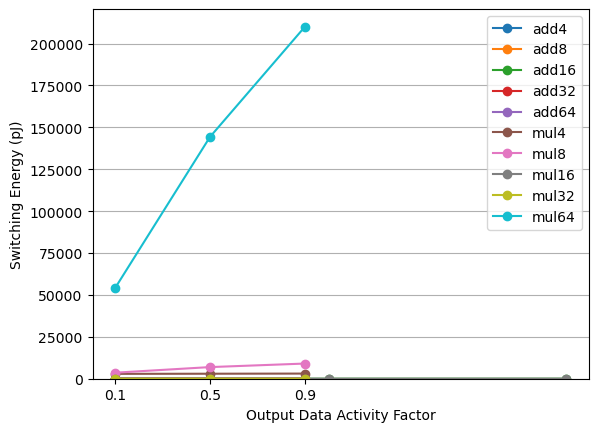

In [112]:
ykey = 'Switching Energy (pJ)'
# ykey = 'Internal (pJ)'

designs =  list(dict.fromkeys(energy['design']).keys())
for design in designs:
    df = energy[~energy['output_af'].isna() & (energy['design'] == design)].sort_values('output_af')
    hd = df['output_af']
    e = df[ykey]
    plt.plot(hd,e,'o-',label=design)
    plt.xticks(hd)


plt.legend()
plt.xlabel('Output Data Activity Factor')
plt.ylabel(ykey)
plt.grid(axis='y')
plt.ylim(bottom=0)
;

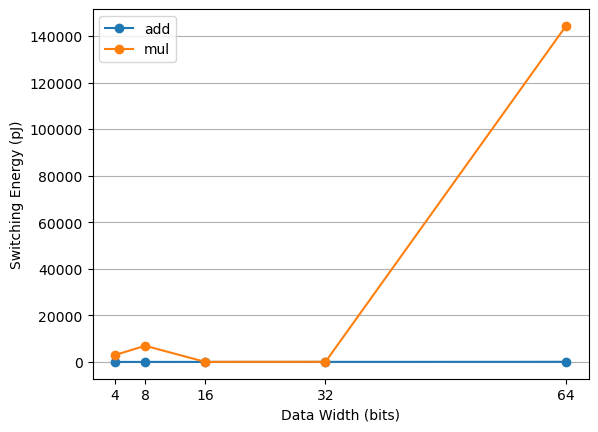

In [113]:
ykey = "Switching Energy (pJ)"

data = energy[energy['output_af'] == 0.5]
for operation in operations:
    widths, skip = [], []
    ind = 0
    for val in data['design']:
        if operation in val:
            widths.append(int(val.replace(operation,'')))
        else:
            skip.append(ind)
        ind += 1
    energies = data[ykey].values
    valid_energies = []
    for i in range(len(energies)):
        if i not in skip:
            valid_energies.append(energies[i])
    # print(widths, valid_energies)
    plt.plot(widths,valid_energies,'o-', label=operation)
    plt.xticks(widths)
plt.legend()
plt.xlabel("Data Width (bits)")
plt.ylabel(ykey)
plt.grid(axis='y')



## Notes
What do we want to test?

Inputs:
* 0 -> 0
* 0 -> 11...11
* different activity factors of adds

Designs:
* minimum critical path - can we force the synthesis tool to use faster gates

Flow:
* sim-rtl > power-rtl